In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization,Dropout
from tensorflow.keras.layers import Activation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from bs4 import BeautifulSoup
import re,string,unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.layers import Dense,LSTM,BatchNormalization
from keras.models import Sequential

[nltk_data] Error loading punkt: <urlopen error [WinError 10051] A
[nltk_data]     socket operation was attempted to an unreachable
[nltk_data]     network>
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TRIDNT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TRIDNT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Viewing And Analysing

In [39]:
raw_data = pd.read_csv(r"C:\Users\TRIDNT\Documents\Codes_and_Stuff\Datasets\financial_sentiment\all-data.csv",encoding='latin1')

In [40]:
df = raw_data.copy()
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [41]:
df = df.rename(columns={df.columns[0]: "Sentiment", df.columns[1]: "text"})
df

,Sentiment,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


In [54]:
from sklearn.utils import resample

# Separate each class
neutral_df = df[df['Sentiment'] == 'neutral']
positive_df = df[df['Sentiment'] == 'positive']
negative_df = df[df['Sentiment'] == 'negative']

# Downsample the neutral class to 1363
neutral_df_downsampled = resample(neutral_df, 
                                  replace=False,    # sample without replacement
                                  n_samples=1363,   # desired number of samples
                                  random_state=42)  # reproducible results

# Upsample the positive and negative classes to 1363
positive_df_upsampled = resample(positive_df, 
                                 replace=True,     # sample with replacement
                                 n_samples=1363,   # desired number of samples
                                 random_state=42)  # reproducible results

negative_df_upsampled = resample(negative_df, 
                                 replace=True,     # sample with replacement
                                 n_samples=1363,   # desired number of samples
                                 random_state=42)  # reproducible results

# Combine the classes into a new balanced DataFrame
balanced_df = pd.concat([neutral_df_downsampled, positive_df_upsampled, negative_df_upsampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution
print(balanced_df['Sentiment'].value_counts())


Sentiment
neutral     1363
positive    1363
negative    1363
Name: count, dtype: int64


In [55]:
balanced_df['Sentiment'].value_counts()

Sentiment
neutral     1363
positive    1363
negative    1363
Name: count, dtype: int64

### Data Pre Processing

In [56]:
# take only the sentiment and text column which is of use to us and then encode relevant to 1 and non relavant to 0
data = balanced_df[['Sentiment','text']]
data['Sentiment'] = LabelEncoder().fit_transform(data['Sentiment'])

#### Neutral - 1 | Positive - 2 | Negative - 0 |

### Text Pre Processing

In [57]:
trial_data = data.copy()

In [58]:
def text_preprocessing(text):
    # Clean text
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Lowercase and tokenize
    text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Stem and lemmatize
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]

    return ' '.join(lemmatized_tokens)  # Join tokens back into a single string

In [59]:
trial_data['text'] = trial_data['text'].apply(text_preprocessing)
trial_data.head()

,Sentiment,text
0,1,januaryseptemb 2007 oper profit total eur 205 mn
1,1,size extens 185 alreadi let gross area 2830 sq...
2,2,finnish construct group lemminkainen oyj hel l...
3,1,alreadi alloc money inventori
4,2,accord seppnen new technolog umts900 solut net...


### Split into Train and Test Data

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X,Y = trial_data['text'],trial_data['Sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 43)
print(f"Training Shape:{x_train.shape}\nTest Shape:{x_test.shape}")

Training Shape:(3271,)
Test Shape:(818,)


In [61]:
y_train.shape

(3271,)

#### Let us now create two different types of word converters - tfidf and countvectorizer

In [62]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(x_train)
X_test_tfidf = tfidf.transform(x_test)

print('tfidf_train:',X_train_tfidf.shape)
print('tfidf_test:',X_test_tfidf.shape)

# cv=CountVectorizer(max_df=1,binary=False,ngram_range=(1,1))

# cv_train_reviews=cv.fit_transform(x_train)
# cv_test_reviews=cv.transform(x_test)

# print('BOW_cv_train:',cv_train_reviews.shape)
# print('BOW_cv_test:',cv_test_reviews.shape)

# Cv has very bad accuracy with this dataset with aroudn 50% only

tfidf_train: (3271, 5854)
tfidf_test: (818, 5854)


### Create the Nueral Network Model


In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
from scipy.sparse import issparse

def model(x_train, x_test, y_train, y_test):
    # Define the Neural Network Model
    NN_Model = Sequential([
        Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(8, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Changed to softmax for multi-class classification
    ])

    # Compile the Model
    NN_Model.compile(optimizer=tf.optimizers.Adam(0.01), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

    # Check if the input data is sparse and convert it to a dense array if necessary
    if issparse(x_train):
        x_train = x_train.toarray()
    if issparse(x_test):
        x_test = x_test.toarray()

    # Train the Model
    NN_Model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_test, y_test))

    # Evaluate the Model
    evaluation = NN_Model.evaluate(x_test, y_test)
    print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

    # Predicting the test set results
    Y_pred = NN_Model.predict(x_test)
    y_pred_final = Y_pred.argmax(axis=1)  # Convert softmax output to class labels

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_test, y_pred_final)
    print(classification_report(y_test, y_pred_final))

    # Plotting the Confusion Matrix
    plt.figure(figsize=(10, 7))
    sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

# Example usage:
# model(x_train, x_test, y_train, y_test)


C:\Users\TRIDNT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3514 - loss: 1.2295 - val_accuracy: 0.3154 - val_loss: 1.1196
Epoch 2/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4479 - loss: 1.0411 - val_accuracy: 0.4914 - val_loss: 0.9604
Epoch 3/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5026 - loss: 0.9553 - val_accuracy: 0.6027 - val_loss: 0.7427
Epoch 4/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5747 - loss: 0.8204 - val_accuracy: 0.6638 - val_loss: 0.6348
Epoch 5/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6240 - loss: 0.7339 - val_accuracy: 0.6540 - val_loss: 0.6108
Epoch 6/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6249 - loss: 0.6904 - val_accuracy: 0.6308 - val_loss: 0.6150
Epoch 7/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6463 - loss: 0.6408 - val_accuracy: 0.6711 - val_loss: 0.6091
Epoch 8/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6479 - loss: 0.6514 - val_accuracy: 0.

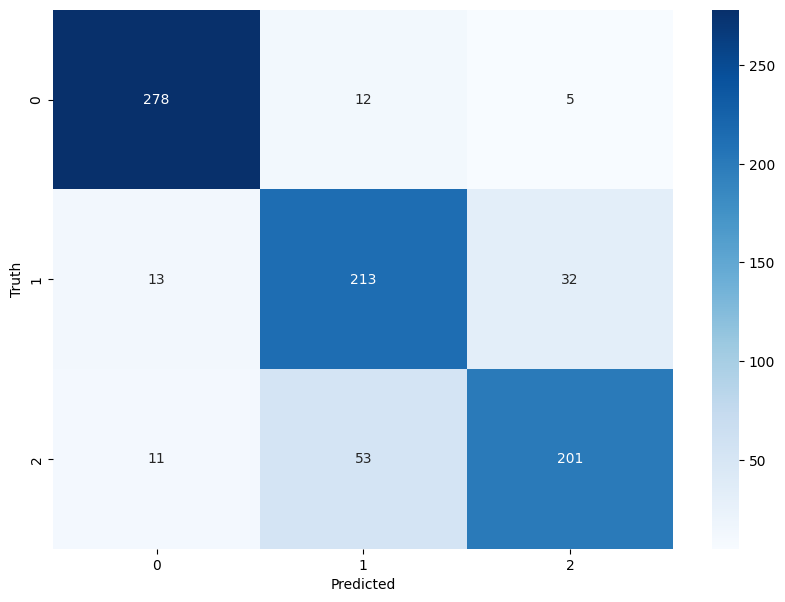

In [64]:
model(X_train_tfidf,X_test_tfidf,y_train, y_test)
# model(cv_train_reviews,cv_test_reviews,y_train, y_test)

### Ok the so final accuracy I'm getting with this datset is around 73%... i have tried various methods and I am not able to achieve a better accuracy so this is it I Guess : Final Accuracy = 73.4%